<a href="https://colab.research.google.com/github/sujatasahoo/Predict-Clearsky-Global-Horizontal-Irradiance/blob/main/Predict_Clearsky_Global_Horizontal_Irradiance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Introduction**

**To predict clearsky global horizontal irradiance(GHI).**

Solar irradiance represents the power from the sun that reaches a surface per unit area in the form of electromagnetic radiation. Direct irradiance is the part of the solar irradiance that directly reaches a surface; diffuse irradiance is the part that is scattered by the atmosphere; global irradiance is the sum of both diffuse and direct components reaching the same surface.

Global Horizontal Irradiation/Irradiance (GHI) is the sum of direct and diffuse radiation received on a horizontal plane. GHI is a reference radiation for the comparison of climatic zones; it is also essential parameter for calculation of radiation on a tilted plane.

GHI: Global Horizontal Irradiation

DNI: Direct Normal Irradiation

DHI: Diffuse Horizontal Irradiation

Global Horizontal Irradiance (GHI) = Direct Normal Irradiance (DNI)* cos(solar zenith angle) + Diffused Horizontal Irradiance (DHI)

GHI = DNI*cosθ + DHI

GHI and DHI are referred to a surface horizontal to the ground, while DNI is referred to a surface perpendicular to the Sun. Higher values of DHI/GHI ratio represent a higher occurrence of clouds, higher atmospheric pollution or higher water vapor content.

Zenith Angle : The angle between the horizontal and the center of the sun's disk is know as zenith angle


Data Attributes:‘Year',
'Month',
'Day',
'Hour',
'Minute',
'Temperature', 0C

'Clearsky DHI', w/m2
'Clearsky DNI', w/m2
'Clearsky GHI', w/m2

'Cloud Type',
    Cloud Type 0    Clear
    Cloud Type 1    Probably Clear
    Cloud Type 2    Fog
    Cloud Type 3    Water
    Cloud Type 4    Super-Cooled Water
    Cloud Type 5    Mixed
    Cloud Type 6    Opaque Ice
    Cloud Type 7    Cirrus
    Cloud Type 8    Overlapping
    Cloud Type 9    Overshooting
    Cloud Type 10    Unknown
    Cloud Type 11    Dust
    Cloud Type 12    Smoke
    Cloud Type -15    N/A
'Dew Point', C
'Fill Flag',
    Fill Flag 0    N/A
    Fill Flag 1    Missing Image
    Fill Flag 2    Low Irradiance
    Fill Flag 3    Exceeds Clearsky
    Fill Flag 4    Missing CLoud Properties
    Fill Flag 5    Rayleigh Violation
    Fill Flag any   N/A

'Relative Humidity', %

'Solar Zenith Angle', Degree to calculate cos(θ)
'Surface Albedo', flux per unit area

'Pressure', mbar
'Precipitable Water', cm

'Wind Direction', Degrees
'Wind Speed' m/s

This is a regression problem.

# **I. Wrangle Data**

In [ ]:
%%capture
import sys
!pip install category_encoders==2.*
!pip install pdpbox
!pip install shap

In [ ]:
directory = '/content/gdrive/MyDrive/ClearskyGHIdataset'

In [ ]:
# mounting your google drive on colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from xgboost import XGBRegressor
from category_encoders import OneHotEncoder
from sklearn.inspection import permutation_importance 
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data = directory+'/train.csv'
df = pd.read_csv(data)
def wrangle(filepath):
  df = pd.read_csv(filepath)
  df['datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day','Minute']])
  #set the index to 
  df.set_index('datetime', inplace = True)

  # Drop Constant Column
  df.columns = df.columns.str.lower().str.replace(' ', '')
  # Drop Duplicate Column
  
  # Drop High Cardinality Columns
  
  # Drop columns with high proportion of null values
  
  df = df.drop(columns=['day', 'hour','minute'])
                      
  df = df.fillna(0)
  df = df.drop(columns=['clearskydhi','clearskydni','solarzenithangle'])
  return df

filepath = data
df = wrangle(filepath)

df.head()

,year,month,clearskyghi,cloudtype,dewpoint,temperature,pressure,relativehumidity,precipitablewater,winddirection,windspeed,fillflag
datetime,,,,,,,,,,,,
2009-01-01 00:00:00,2009,1,0,0,0.0,5.0,1010,75.34,0.499,346.1,3.1,0
2009-01-01 00:30:00,2009,1,0,0,1.0,5.0,1010,80.81,0.490,346.1,3.1,0
2009-01-01 00:00:00,2009,1,0,4,0.0,5.0,1010,78.27,0.482,347.9,3.2,0
2009-01-01 00:30:00,2009,1,0,4,0.0,4.0,1010,78.27,0.478,347.9,3.1,0
2009-01-01 00:00:00,2009,1,0,4,0.0,4.0,1010,76.45,0.475,350.0,3.0,0


In [ ]:
df.shape

(175296, 12)

In [ ]:
df.isnull().sum().sum()

0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175296 entries, 2009-01-01 00:00:00 to 2018-12-31 00:30:00
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   year               175296 non-null  int64  
 1   month              175296 non-null  int64  
 2   clearskyghi        175296 non-null  int64  
 3   cloudtype          175296 non-null  int64  
 4   dewpoint           175296 non-null  float64
 5   temperature        175296 non-null  float64
 6   pressure           175296 non-null  int64  
 7   relativehumidity   175296 non-null  float64
 8   precipitablewater  175296 non-null  float64
 9   winddirection      175296 non-null  float64
 10  windspeed          175296 non-null  float64
 11  fillflag           175296 non-null  int64  
dtypes: float64(6), int64(6)
memory usage: 17.4 MB


In [ ]:
df.describe()

,year,month,clearskyghi,cloudtype,dewpoint,temperature,pressure,relativehumidity,precipitablewater,winddirection,windspeed,fillflag
count,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000
mean,2013.500274,6.523549,254.365490,2.540474,13.564431,18.266769,1003.185230,79.376366,2.903732,188.877796,2.262871,0.740433
std,2.871908,3.448543,327.705006,3.021879,8.196787,8.943096,5.935749,19.678235,1.546979,99.014733,1.281902,6.575655
min,2009.000000,1.000000,0.000000,0.000000,-17.000000,-9.000000,970.000000,7.190000,0.122000,0.000000,0.000000,0.000000
25%,2011.000000,4.000000,0.000000,0.000000,8.000000,12.000000,1000.000000,65.590000,1.534000,97.400000,1.300000,0.000000
50%,2013.500000,7.000000,0.000000,1.000000,15.000000,20.000000,1000.000000,84.230000,2.866000,200.000000,2.000000,0.000000
75%,2016.000000,10.000000,535.000000,6.000000,21.000000,25.000000,1010.000000,97.950000,4.223000,272.000000,3.000000,0.000000
max,2018.000000,12.000000,1063.000000,10.000000,26.900000,40.000000,1024.000000,100.000000,7.700000,360.000000,12.900000,100.000000


In [ ]:
df['clearskyghi']

datetime
2009-01-01 00:00:00      0
2009-01-01 00:30:00      0
2009-01-01 00:00:00      0
2009-01-01 00:30:00      0
2009-01-01 00:00:00      0
                      ... 
2018-12-31 00:30:00    168
2018-12-31 00:00:00     84
2018-12-31 00:30:00     18
2018-12-31 00:00:00      0
2018-12-31 00:30:00      0
Name: clearskyghi, Length: 175296, dtype: int64

In [ ]:
data1= directory+'/test.csv'
filepath= data1
df_test = pd.read_csv(filepath)
df_test = wrangle(filepath)
df_test.head()


,year,month,cloudtype,dewpoint,temperature,pressure,relativehumidity,precipitablewater,winddirection,windspeed,fillflag,clearskyghi
datetime,,,,,,,,,,,,
2019-01-01 00:00:00,2019,1,7,18.4,18.8,1008,97.70,3.5,190,2.3,0,0.0
2019-01-01 00:30:00,2019,1,3,18.4,18.6,1008,98.92,3.5,187,2.5,0,0.0
2019-01-01 00:00:00,2019,1,3,18.2,18.5,1008,98.35,3.5,184,2.8,0,0.0
2019-01-01 00:30:00,2019,1,3,18.2,18.3,1008,99.58,3.5,185,3.0,0,0.0
2019-01-01 00:00:00,2019,1,0,18.0,18.0,1008,99.71,3.6,186,3.1,0,0.0


In [ ]:
df_test.shape

(17520, 12)

# **II. Split Data**

I. The dataset splited into the feature matrix X and the target vector y

In [ ]:
target ='clearskyghi'
y = df[target]
X = df.drop(columns = target)
X.shape

(175296, 11)

II.The training data set using a randomized split, divide X and y into a training set (X_train, y_train) and a validation set (X_val, y_val).



In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state = 42)
X_val.shape

(35060, 11)

### I.Spliting the test data set

In [ ]:
target ='clearskyghi'
y_test = df_test[target]
X_test = df_test.drop(columns = target)
X.shape


(175296, 11)

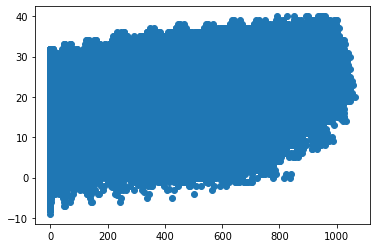

In [ ]:
plt.scatter(x= df['clearskyghi'], y= df['temperature'])

# III. Establish Baseline



Since this is a regression problem, need to find the baseline mean absolute error for your model.

In [ ]:
Mean =y_train.mean()
y_pred = [y_train.mean()] * len(y_train)
baseline_mae = mean_absolute_error(y_train,y_pred )
print('Mean:', Mean)
print('Baseline MAE:', baseline_mae)


Mean: 254.11781568213584
Baseline MAE: 289.18573524033707


# IV. Build Models

Build and train model. 

Build a Pipeline named model, and fit it to your training data. Pipeline include:

an OrdinalEncoder transformer for categorical features.

a SimpleImputer transformer fot missing values.




In [ ]:
#model_lr = LinearRegression()
#model_r = Ridge()
#model_rf = RandomForestRegressor(n_jobs=-1, random_state=42
#model_xgb = XGBRegressor(random_state=42, n_jobs=-1)


In [ ]:
model_lr = make_pipeline(OrdinalEncoder(),
                           SimpleImputer(),
                           StandardScaler(), 
                      LinearRegression())
model_lr.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [ ]:
model_r = Ridge(alpha = 1.0)
model_r.fit(X_train,y_train)

Ridge()

In [ ]:
model_rf = make_pipeline(OrdinalEncoder(),
                           SimpleImputer(),
                           StandardScaler(), 
                      RandomForestRegressor(n_jobs=-1,n_estimators=25,max_depth= 25, random_state=42))
model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=25, n_estimators=25, n_jobs=-1,
                                       random_state=42))])

In [ ]:
model_xgb = make_pipeline(OrdinalEncoder(),
                           SimpleImputer(),
                           StandardScaler(), 
                           XGBRegressor(random_state=42, n_jobs=-1))
model_xgb.fit(X_train, y_train);

[14:46:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# V. Check Metrics

In [ ]:
# Linear Regression
training_lr = mean_absolute_error(y_train, model_lr.predict(X_train))
val_lr = mean_absolute_error(y_val, model_lr.predict(X_val))

print('Training MAE:', training_lr)
print('Validation MAE:', val_lr)

Training MAE: 160.7409364376212
Validation MAE: 160.7818937523883


In [ ]:
training_r = mean_absolute_error(y_train, model_r.predict(X_train))
val_r = mean_absolute_error(y_val, model_r.predict(X_val))
print('Training MAE:', training_r)
print('Validation MAE:', val_r)

Training MAE: 160.74094058404523
Validation MAE: 160.78189596315403


In [ ]:
training_rf = mean_absolute_error(y_train, model_rf.predict(X_train))
val_rf = mean_absolute_error(y_val, model_rf.predict(X_val))
print('Training MAE:', training_rf)
print('Validation MAE:', val_rf)

Training MAE: 25.034998422402666
Validation MAE: 65.16344515266874


In [ ]:
training_xgb = mean_absolute_error(y_train, model_xgb.predict(X_train))
val_xgb = mean_absolute_error(y_val, model_xgb.predict(X_val))
print('Training MAE:', training_xgb)
print('Validation MAE:', val_xgb)

Training MAE: 119.76256574026804
Validation MAE: 120.57408930832956


In [ ]:
# Caculate R^2 score
print('Training R^2:',model_lr.score(X_train, y_train))

Training R^2: 0.6035626763183035


In [ ]:
print('Training R^2:',model_r.score(X_train, y_train))

Training R^2: 0.6035626763165236


In [ ]:
print('Training R^2:',model_rf.score(X_train, y_train))

Training R^2: 0.9829669593911612


In [ ]:
print('Validation R^2:', model_rf.score(X_val, y_val))

Validation R^2: 0.8935871606500266


In [ ]:
print('Training R^2:',model_xgb.score(X_train, y_train))

Training R^2: 0.7348531321145797


In [ ]:
print('Validation R^2:', model_xgb.score(X_val, y_val))

Validation R^2: 0.7312685739846622


In [ ]:
print('Validation R^2:', model_lr.score(X_val, y_val))

Validation R^2: 0.6035289373124623


# VI. Communicating Results



In [ ]:
import calendar
def month_toname(num):
  return calendar.month_name[num]

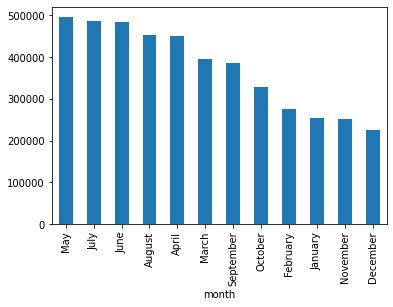

In [ ]:
import calendar
list(calendar.month_name)
year_2018 = df[df['year']==2018]
fig,ax = plt.subplots()
year_2018['month']= year_2018['month'].apply(month_toname)
#ax.bar(year_2018.groupby('month').sum()['clearskyghi'].sort_values(ascending=False))

year_2018.groupby('month').sum()['clearskyghi'].sort_values(ascending=False).plot(kind='bar')

In [ ]:
year_2018

,year,month,clearskyghi,cloudtype,dewpoint,temperature,pressure,relativehumidity,precipitablewater,winddirection,windspeed,fillflag
datetime,,,,,,,,,,,,
2018-01-01 00:00:00,2018,January,0,4,1.7,3.3,1013,88.94,1.8,345.0,2.8,0
2018-01-01 00:30:00,2018,January,0,2,1.7,3.1,1013,90.20,1.8,347.0,2.8,0
2018-01-01 00:00:00,2018,January,0,0,1.1,2.9,1013,88.22,1.7,349.0,2.9,0
2018-01-01 00:30:00,2018,January,0,2,1.1,2.7,1013,89.48,1.7,351.0,2.9,0
2018-01-01 00:00:00,2018,January,0,2,0.7,2.5,1013,87.75,1.6,353.0,2.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 00:30:00,2018,December,168,4,19.4,20.8,1008,91.77,3.7,204.0,3.5,100
2018-12-31 00:00:00,2018,December,84,4,19.1,20.1,1008,93.88,3.8,209.0,3.2,100
2018-12-31 00:30:00,2018,December,18,7,19.1,19.6,1008,96.83,3.8,208.0,2.6,57


# I. Feature Importances

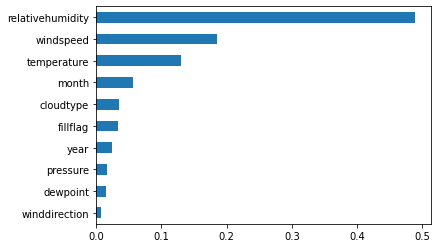

In [ ]:
importances = model_xgb.named_steps['xgbregressor'].feature_importances_
feature_names =X_train.columns
feat_imp= pd.Series(data=importances, index=feature_names).sort_values()
feat_imp.tail(10).plot(kind='barh')


## Partial Dependence Plots
 



In [ ]:
perm_imp = permutation_importance(model_xgb, X_val, y_val,random_state=42)
perm_imp

{'importances': array([[0.0217971 , 0.02370145, 0.02228607, 0.02231947, 0.02242683],
        [0.11059901, 0.11003669, 0.11043364, 0.11011077, 0.11420897],
        [0.01710776, 0.01594163, 0.01598584, 0.01624645, 0.01644051],
        [0.00625505, 0.00664427, 0.00606813, 0.00661692, 0.00630977],
        [0.44712135, 0.44716334, 0.44573882, 0.45544416, 0.44971508],
        [0.00472506, 0.00481375, 0.00483828, 0.00505578, 0.00505796],
        [0.50917681, 0.51526196, 0.51851259, 0.51156906, 0.51141776],
        [0.00252171, 0.00300219, 0.00300566, 0.00241081, 0.00286582],
        [0.00283331, 0.00265405, 0.00251025, 0.00270863, 0.00257079],
        [0.15577656, 0.15444727, 0.15438808, 0.15187659, 0.15589205],
        [0.00621108, 0.00630448, 0.0061484 , 0.00658324, 0.00643865]]),
 'importances_mean': array([0.02250618, 0.11107782, 0.01634444, 0.00637883, 0.44903655,
        0.00489817, 0.51318763, 0.00276124, 0.00265541, 0.15447611,
        0.00633717]),
 'importances_std': array([0.000635

In [ ]:
data_perm = {'imp_mean':perm_imp['importances_mean'],
             'imp_std':perm_imp['importances_std']}

In [ ]:
df_xgb = pd.DataFrame(data_perm, index=X_val.columns).sort_values('imp_mean')
df_xgb

,imp_mean,imp_std
winddirection,0.002655,0.000112
precipitablewater,0.002761,0.000249
pressure,0.004898,0.000135
fillflag,0.006337,0.000157
dewpoint,0.006379,0.000221
cloudtype,0.016344,0.000422
year,0.022506,0.000636
month,0.111078,0.001579
windspeed,0.154476,0.001447
temperature,0.449037,0.003452


In [ ]:
feature = 'relativehumidity'

In [ ]:
isolate= pdp_isolate(
    model_xgb,
    dataset= X_val, # USE YOUR VALIDATION DATA
    model_features=X_val.columns,
    feature=feature
)

Cleasky(GHI) depends on relativehumidity.

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8ef95a77d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8ef6177e50>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


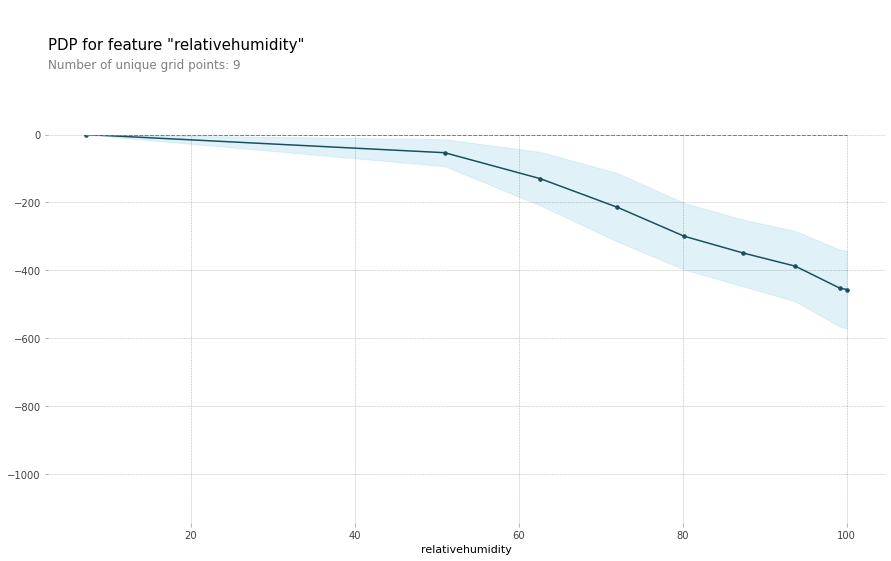

In [ ]:
pdp_plot(isolate, feature_name=feature)